In [4]:
%matplotlib widget

import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal
from scipy.fft import fftshift

### Summary

This book loads in a WAV file, will plot the channel time data and spectra. It then plots spectrograms for each channel.

The plots are interactive - viewing them in a booklet will allow one to zoom in and play around with the data

In [64]:


# Replace 'your_file_path.wav' with the path to your WAV file
file_path = 'D:\\Recordings_All\\HarbourTest\\Audio_fs_44100_Chans_4_1704612914_ambient.wav'
 
# Separate channels into individual arrays
channel_data = []
sample_rate = -1
num_channels= -1

# Open the WAV file
with wave.open(file_path, 'rb') as wav_file:
    num_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    num_frames = wav_file.getnframes()
    frame_rate = wav_file.getframerate()
    sample_rate = wav_file.getframerate()

    # Read audio frames from the WAV file
    frames = wav_file.readframes(num_frames)

    # Convert the binary data to a NumPy array
    audio_data = np.frombuffer(frames, dtype=np.int16)
   
    for i in range(num_channels):
        channel = audio_data[i::num_channels]
        channel_data.append(channel)


print("Channel count (n): " + str(num_channels))
print("Sample rate (Hz): " + str(sample_rate))
print("Recording length (s): " + str(len(channel_data[0])* 1/sample_rate))

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Recordings_All\\HarbourTest2\\Audio_fs_44100_Chans_4_1704612914_ambient.wav'

### Time and Freq Plot

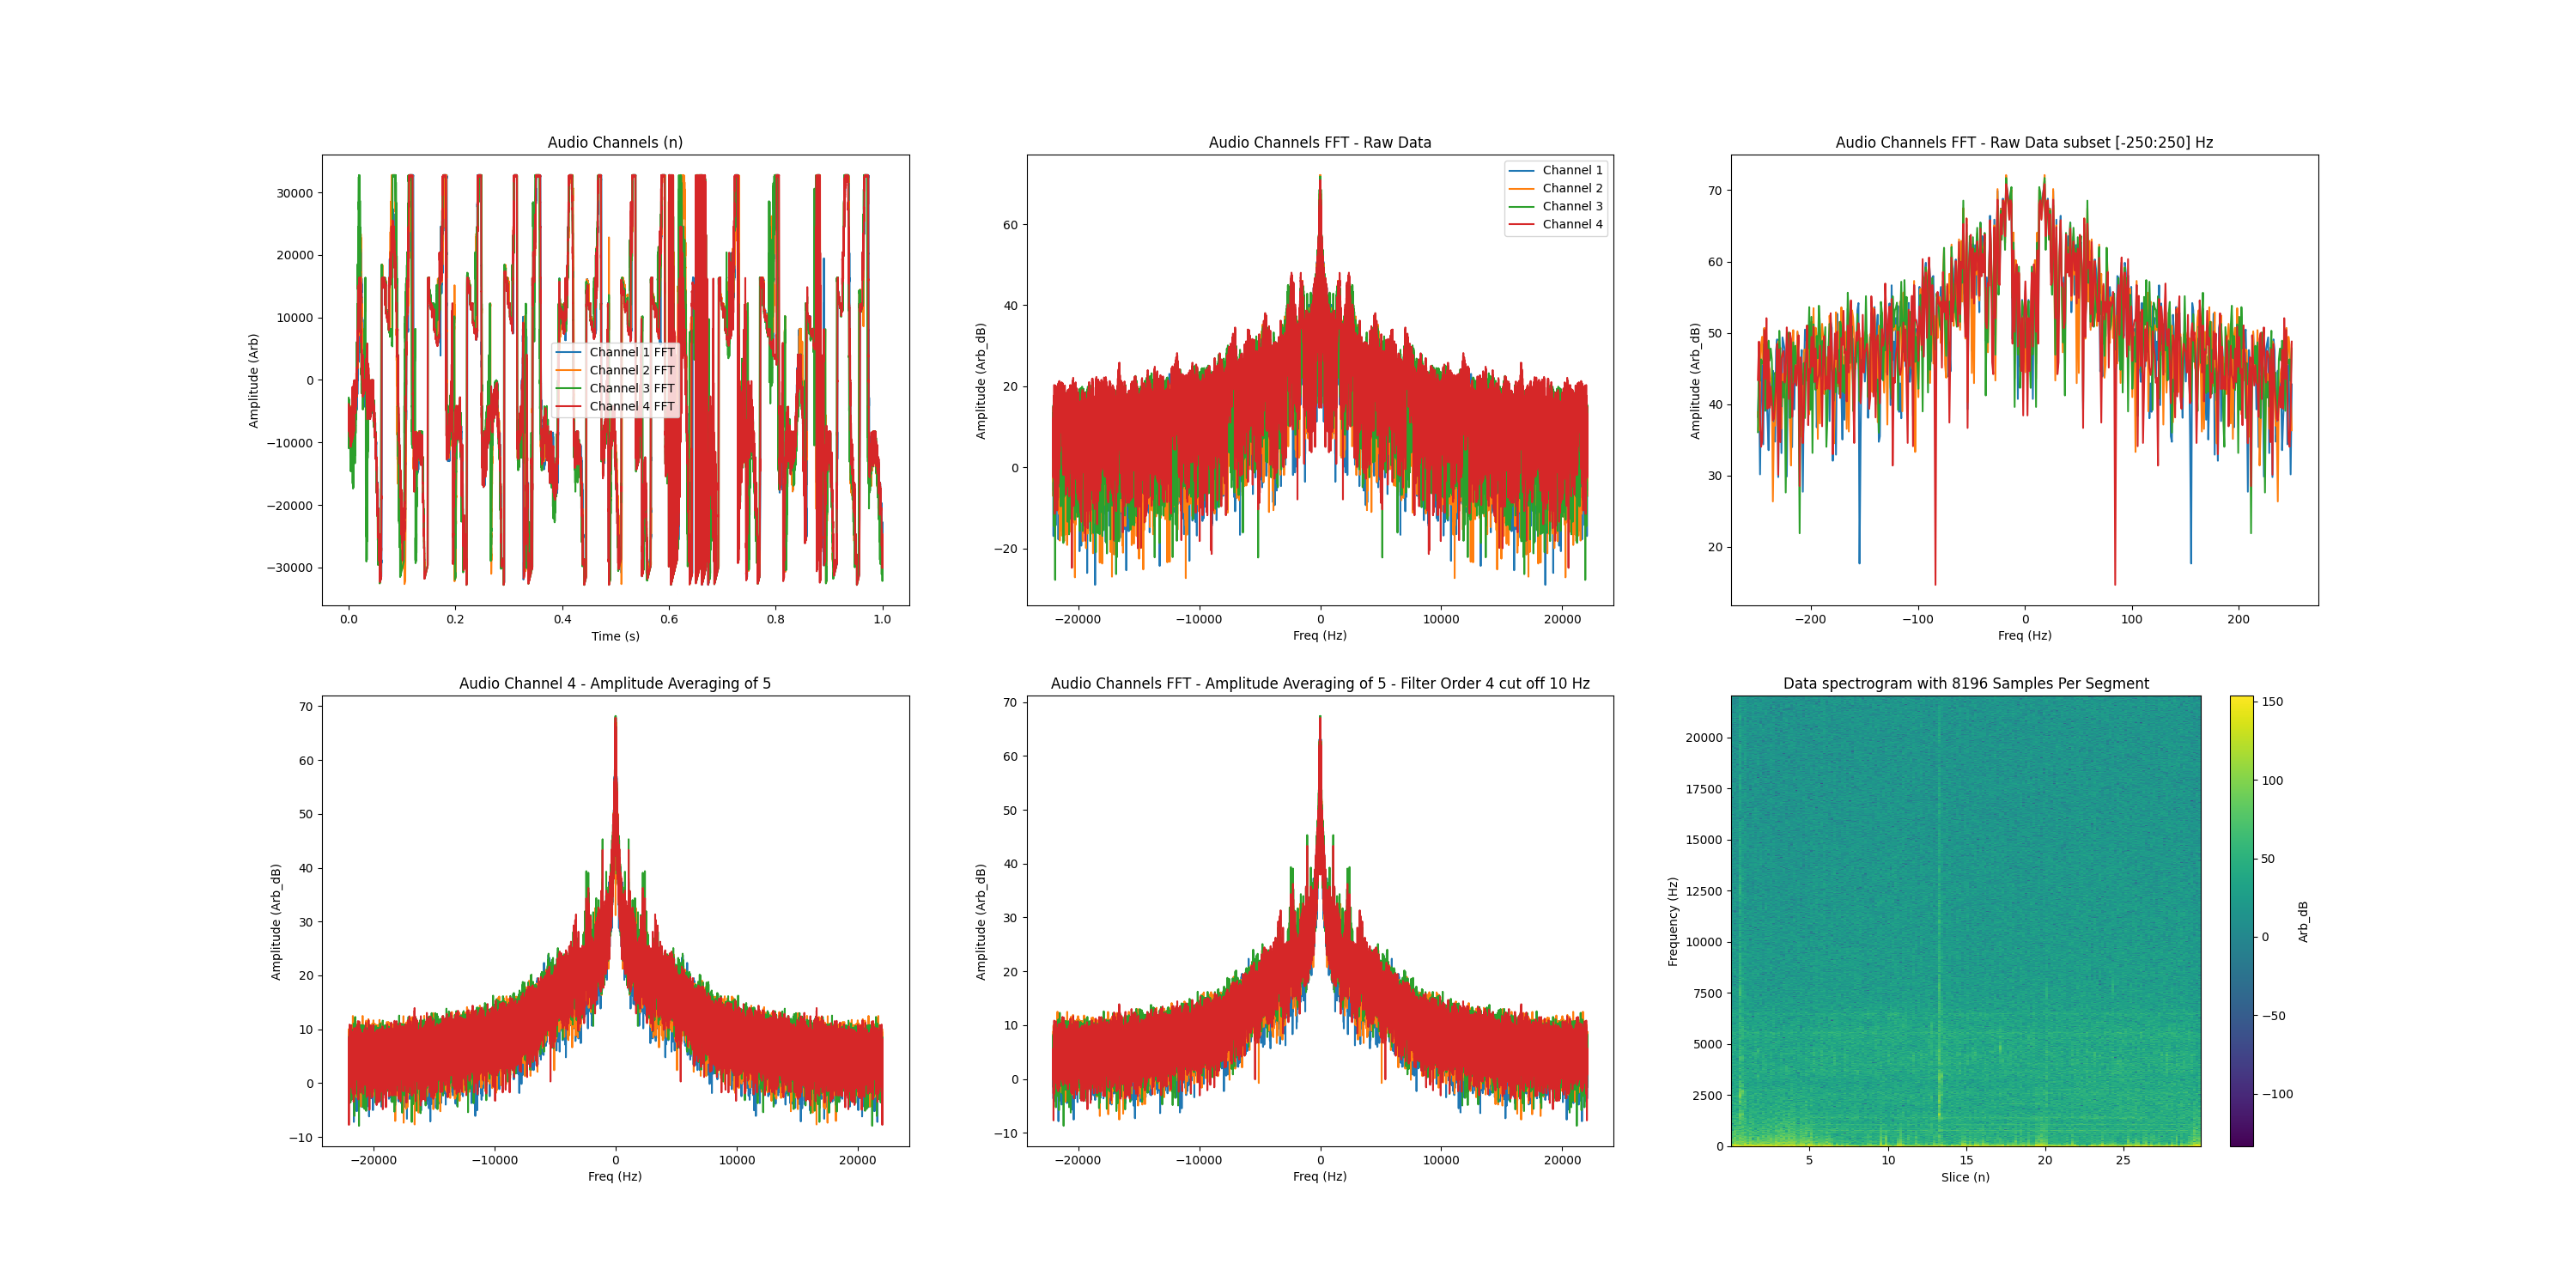

In [61]:
# Plot each channel
period_to_plot = 1 # seconds
averaging_count = 5
channel_of_interest = 3

sample_count = int(period_to_plot*sample_rate)
frequecy_band_of_interest = 250

# Create a low-pass Butterworth filter
cutoff_frequency = 10  # Adjust this cutoff frequency as needed (Hz)
order = 4  # Filter order

spectrogram_samples_per_segment = 8196

# Turn on interactive mode
if True:

    plt.ion()

    fig, ax = plt.subplots(2,3, figsize=(30, 15))
    time_axis = np.linspace(0,1,sample_count)
    freq_axis = np.linspace(0,sample_count,sample_count)* (sample_rate/sample_count) - sample_rate/2
    frequency_index_bound = int(frequecy_band_of_interest/(sample_rate/sample_count)) 

    # Time domain plot
    for i, channel in enumerate(channel_data):
        ax[0,0].plot(time_axis, channel[:sample_count], label=f'Channel {i + 1} FFT')

    ax[0,0].set_xlabel('Time (s)')
    ax[0,0].set_ylabel('Amplitude (Arb)')
    ax[0,0].set_title('Audio Channels (n)')
    ax[0,0].legend()


    # FFT and FFT Subset plot
    centre_freq_index = int(len(freq_axis)/2)
    bound_space = 250
    upper_bound = centre_freq_index + frequency_index_bound
    lower_bound = centre_freq_index - frequency_index_bound
    
    for i, channel in enumerate(channel_data):
        fft_data_db = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(channel[:sample_count])))/sample_count)
        
        ax[0,1].plot(freq_axis, fft_data_db, label=f'Channel {i + 1}')
        ax[0,2].plot(freq_axis[lower_bound:upper_bound],fft_data_db[lower_bound:upper_bound], label=f'Channel {i + 1}')
                     
    ax[0,1].set_xlabel('Freq (Hz)')
    ax[0,1].ticklabel_format(useOffset=False)
    ax[0,1].set_ylabel('Amplitude (Arb_dB)')
    ax[0,1].set_title('Audio Channels FFT - Raw Data')
    ax[0,1].legend()
    
    ax[0,2].set_title(f'Audio Channels FFT - Raw Data subset [{-frequecy_band_of_interest}:{frequecy_band_of_interest}] Hz')
    ax[0,2].set_xlabel('Freq (Hz)')
    ax[0,2].set_ylabel('Amplitude (Arb_dB)')

    

    # Incoherent gain
    for i, channel in enumerate(channel_data):
        
        averaged_fft_data = np.zeros((sample_count))

        for j in range(averaging_count):
            fft_data_tmp = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(channel[j*sample_count:(j+1)*sample_count])))/sample_count)
            averaged_fft_data += fft_data_tmp
        
        ax[1,0].plot(freq_axis, averaged_fft_data/averaging_count, label=f'Channel {i + 1}')

    ax[1,0].set_title(f'Audio Channel {channel_of_interest + 1} - Amplitude Averaging of {averaging_count}')
    ax[1,0].set_xlabel('Freq (Hz)')
    ax[1,0].set_ylabel('Amplitude (Arb_dB)')


    # filtered incoherent gain
    nyquist = 0.5 * sample_rate  # Nyquist frequency for a signal sampled at sample_rate
    normalized_cutoff = cutoff_frequency / nyquist
    b, a = signal.butter(order, normalized_cutoff, btype='high') 
        
    for i, channel in enumerate(channel_data):
        
        averaged_fft_data = np.zeros((sample_count))
        filtered_channel = signal.filtfilt(b, a, channel)

        for j in range(averaging_count):
            fft_data_tmp = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(filtered_channel[j*sample_count:(j+1)*sample_count])))/sample_count)
            averaged_fft_data += fft_data_tmp
        
        ax[1,1].plot(freq_axis, averaged_fft_data/averaging_count, label=f'Channel {i + 1}')

    ax[1,1].set_title(f'Audio Channels FFT - Amplitude Averaging of {averaging_count} - Filter Order {order} cut off {cutoff_frequency} Hz')
    ax[1,1].set_xlabel('Freq (Hz)')
    ax[1,1].set_ylabel('Amplitude (Arb_dB)')
     

    f_Sxx1, t_Sxx1, Sxx1 = signal.spectrogram(channel_data[0], fs=sample_rate,  nperseg=spectrogram_samples_per_segment)
    a = ax[1,2].pcolormesh(t_Sxx1, f_Sxx1, 20*np.log10(Sxx1))
    plt.colorbar(a, ax=ax[1,2], label="Arb_dB")
    ax[1,2].set_title(f'Data spectrogram with {spectrogram_samples_per_segment} Samples Per Segment')
    ax[1,2].set_xlabel('Slice (n)')
    ax[1,2].set_ylabel('Frequency (Hz)')


    plt.show()


### Spectrogram Plot

#### Amplitude Data

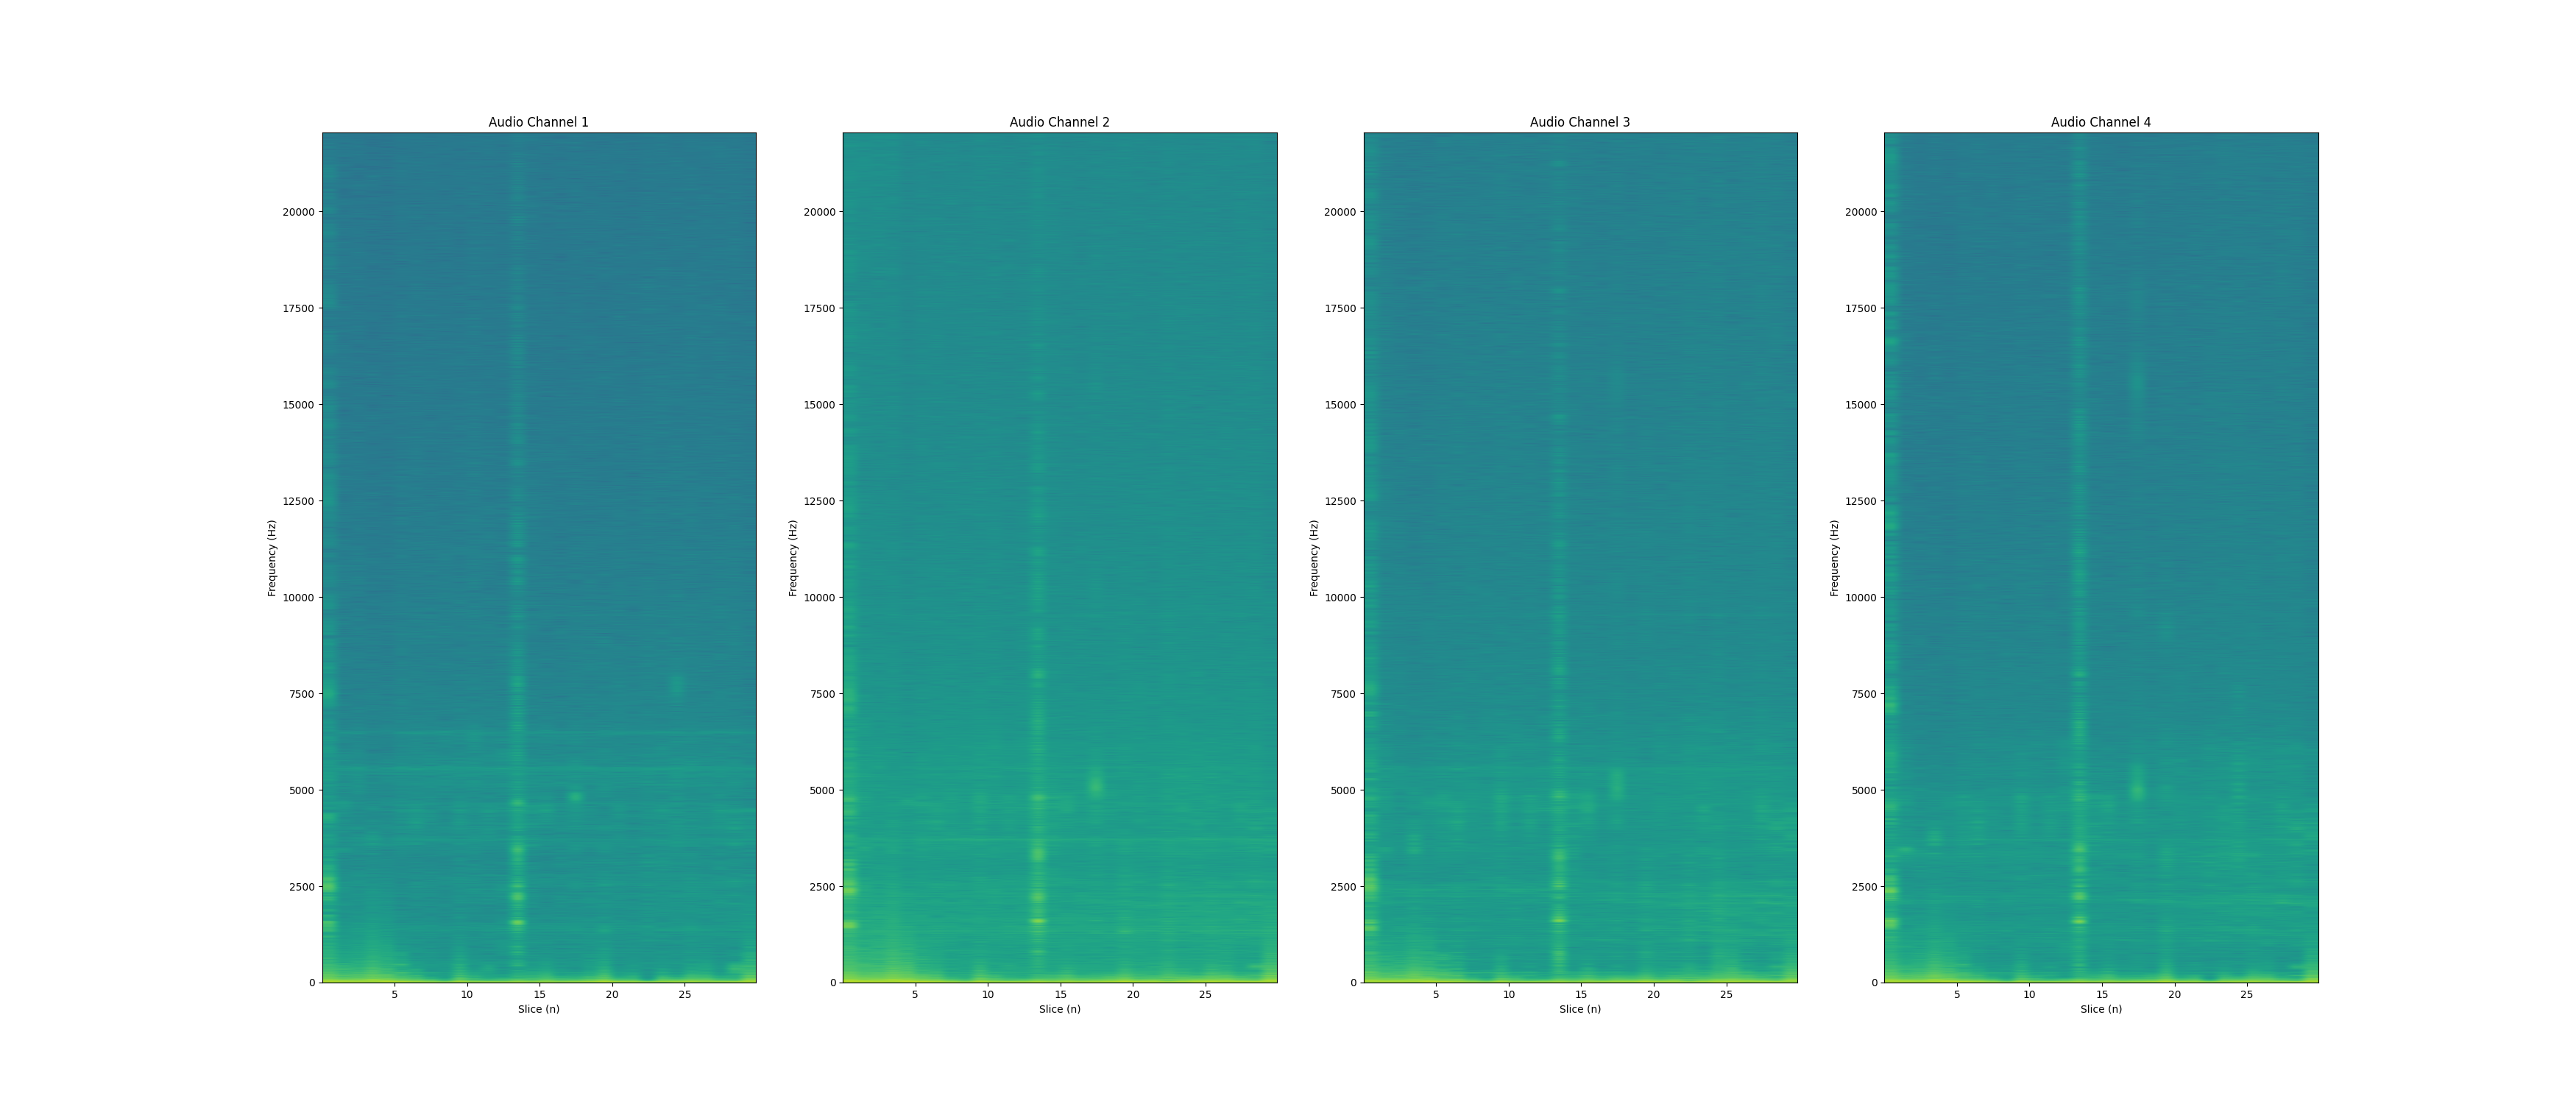

In [62]:
if True:
    
    plt.ion()
    fig1, ax = plt.subplots(1,num_channels, figsize=(35, 15))
    fft_size = 44100

    for i, channel in enumerate(channel_data):
        ax[i].specgram(channel,Fs=sample_rate,NFFT=fft_size)
        ax[i].set_ylabel('Frequency (Hz)')
        ax[i].set_xlabel('Slice (n)')
        ax[i].set_title(f'Audio Channel {i + 1}')

        f_Sxx1, t_Sxx1, Sxx1 = signal.spectrogram(channel, fs=sample_rate,  nperseg=fft_size)


    plt.show()

#### Channel Phase Analysis

Differential phase between channel 1 and 2

Frequency of interest 20 at index 7


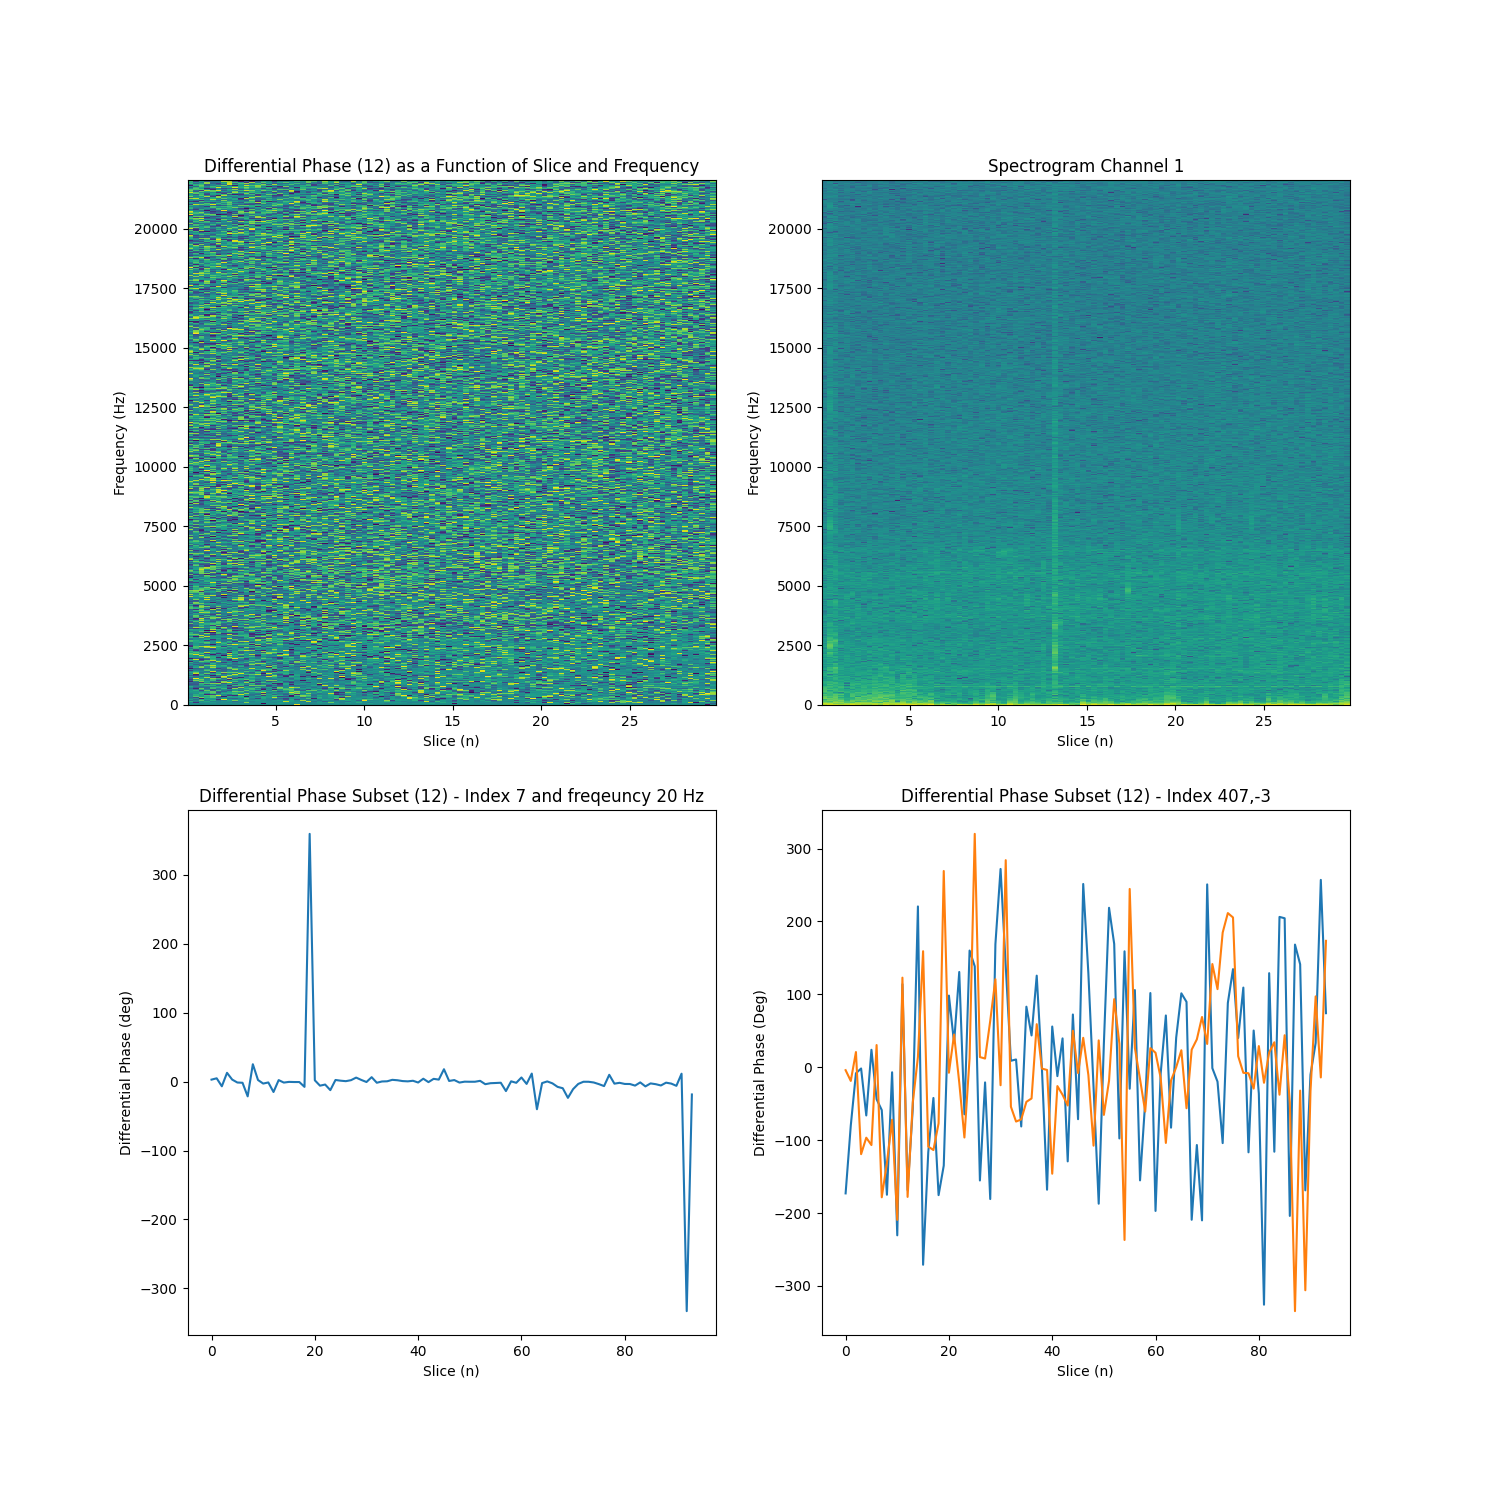

In [63]:
if True:
    
    # Calculate the spectrogram for both channels
    nperseg = 16000
    frequecy_of_interest = 20 # Hz0
    index_of_interest = int(frequecy_of_interest/(sample_rate/nperseg)) 
    print(f'Frequency of interest {frequecy_of_interest} at index {index_of_interest}')
          
    plt.clf()
    plt.ion()
    fig, ax = plt.subplots(2,2, figsize=(15, 15))

   
    f_Sxx1, t_Sxx1, Sxx1 = signal.spectrogram(channel_data[0], fs=sample_rate,  nperseg=nperseg)
    f_Axx1, t_Axx1, Axx1 = signal.spectrogram(channel_data[0], fs=sample_rate, nperseg=nperseg,mode='angle')
    f_Axx2, t_Axx2, Axx2 = signal.spectrogram(channel_data[1], fs=sample_rate, nperseg=nperseg,mode='angle')

    ax[0,0].pcolormesh(t_Sxx1, f_Sxx1, Axx1-Axx2)
    ax[0,0].set_title('Differential Phase (12) as a Function of Slice and Frequency')
    ax[0,0].set_xlabel('Slice (n)')
    ax[0,0].set_ylabel('Frequency (Hz)')

    ax[0,1].pcolormesh(t_Axx1, f_Axx1 ,20*np.log10(Sxx1))
    ax[0,1].set_title('Spectrogram Channel 1')
    ax[0,1].set_xlabel('Slice (n)')
    ax[0,1].set_ylabel('Frequency (Hz)')

    ax[1,0].plot(np.squeeze((Axx1-Axx2)[index_of_interest,:])*180/np.pi) 
    ax[1,0].set_xlabel('Slice (n)')
    ax[1,0].set_ylabel('Differential Phase (deg)')
    ax[1,0].set_title(f'Differential Phase Subset (12) - Index {index_of_interest} and freqeuncy {frequecy_of_interest} Hz')  

    ax[1,1].plot(np.squeeze((Axx1-Axx2)[index_of_interest-10,:])*180/np.pi) 
    ax[1,1].plot(np.squeeze((Axx1-Axx2)[index_of_interest+400,:])*180/np.pi) 
    ax[1,1].set_xlabel('Slice (n)')
    ax[1,1].set_ylabel('Differential Phase (Deg)')
    ax[1,1].set_title(f'Differential Phase Subset (12) - Index {index_of_interest+400},{index_of_interest-10}')

    plt.show()